In [1]:
!pip install requests pandas matplotlib seaborn folium geopandas

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime
from pathlib import Path
from pandas import merge_asof

In [3]:
# NASA FIRMS API Parameters
API_KEY = "9a0fe26c26a9afb0b2090ccaca84d1f9"
DATASET = "VIIRS_NOAA20_NRT"
DAY_RANGE = "7"
WEST, SOUTH, EAST, NORTH = -125.0, 24.0, -66.9, 49.5  # US bounding box

firms_path = Path("data/raw/wildfire_firms.csv")
firms_path.parent.mkdir(parents=True, exist_ok=True)

# Request data
url = f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{API_KEY}/{DATASET}/{WEST},{SOUTH},{EAST},{NORTH}/{DAY_RANGE}"
r = requests.get(url)
r.raise_for_status()
firms_path.write_bytes(r.content)
print("✅ Saved FIRMS data to", firms_path)


✅ Saved FIRMS data to data/raw/wildfire_firms.csv


In [4]:
TOKEN = "KeYXskvBlOVOThnCLDcsTRNIftNukRuq"
headers = {'token': TOKEN}

params = {
    'datasetid': 'GHCND',
    'locationid': 'FIPS:US',
    'startdate': '2025-10-09',
    'enddate': '2025-10-16',
    'limit': 1000
}

url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
r = requests.get(url, headers=headers, params=params)
r.raise_for_status()

out = r.json()
Path("data/raw/weather_noaa.json").write_text(json.dumps(out))
print("✅ Saved NOAA weather data")

✅ Saved NOAA weather data


In [5]:
# Load FIRMS
firms = pd.read_csv(firms_path)
firms['acq_date'] = pd.to_datetime(firms['acq_date'])
firms = firms.rename(columns={'latitude': 'lat', 'longitude': 'lon'})

# Load NOAA JSON
with open("data/raw/weather_noaa.json") as f:
    weather_raw = json.load(f)

weather = pd.json_normalize(weather_raw.get('results', []))
weather['date'] = pd.to_datetime(weather['date'], errors='coerce')
weather = weather.rename(columns={'value': 'measurement_value'})
weather = weather[['station', 'date', 'datatype', 'measurement_value']]

print("FIRMS shape:", firms.shape)
print("NOAA shape:", weather.shape)

FIRMS shape: (9360, 14)
NOAA shape: (1000, 4)


In [6]:
weather_pivot = (
    weather
    .pivot_table(index='date', columns='datatype', values='measurement_value', aggfunc='mean')
    .reset_index()
)

print("✅ NOAA pivoted shape:", weather_pivot.shape)
print(weather_pivot.head())

✅ NOAA pivoted shape: (1, 11)
datatype       date  DAPR  MDPR    PRCP  SNOW  SNWD   TMAX        TMIN  \
0        2025-10-09   2.8  51.8  7.4375   0.0   0.0  311.5  237.294118   

datatype        TOBS  WESD  WESF  
0         256.916667   0.0   0.0  


In [7]:
firms_clean = firms.drop_duplicates()
firms_clean['latitude_rounded'] = firms_clean['lat'].round(1)
firms_clean['longitude_rounded'] = firms_clean['lon'].round(1)
firms_clean = firms_clean[['acq_date', 'lat', 'lon', 'latitude_rounded', 'longitude_rounded',
                           'bright_ti4', 'bright_ti5', 'frp', 'confidence', 'daynight']]
print("✅ FIRMS cleaned:", firms_clean.shape)

✅ FIRMS cleaned: (9360, 10)


In [8]:
# Sort for merge_asof
firms_sorted = firms_clean.sort_values('acq_date')
weather_sorted = weather_pivot.sort_values('date')

# Nearest-date merge (±3 days)
merged_df = merge_asof(
    firms_sorted,
    weather_sorted,
    left_on='acq_date',
    right_on='date',
    direction='nearest',
    tolerance=pd.Timedelta('3 days')
)

print("✅ Final merged dataset shape:", merged_df.shape)
merged_df.head()

✅ Final merged dataset shape: (9360, 21)


,acq_date,lat,lon,latitude_rounded,longitude_rounded,bright_ti4,bright_ti5,frp,confidence,daynight,...,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WESF
0,2025-10-12,42.80183,-80.10732,42.8,-80.1,295.22,281.51,0.63,n,N,...,2.8,51.8,7.4375,0.0,0.0,311.5,237.294118,256.916667,0.0,0.0
1,2025-10-12,36.38562,-114.87799,36.4,-114.9,303.96,285.97,0.54,n,N,...,2.8,51.8,7.4375,0.0,0.0,311.5,237.294118,256.916667,0.0,0.0
2,2025-10-12,36.45271,-120.30569,36.5,-120.3,304.26,285.19,0.99,n,N,...,2.8,51.8,7.4375,0.0,0.0,311.5,237.294118,256.916667,0.0,0.0
3,2025-10-12,36.66381,-120.13683,36.7,-120.1,299.56,282.63,0.57,n,N,...,2.8,51.8,7.4375,0.0,0.0,311.5,237.294118,256.916667,0.0,0.0
4,2025-10-12,36.70210,-119.89320,36.7,-119.9,295.97,285.14,0.65,n,N,...,2.8,51.8,7.4375,0.0,0.0,311.5,237.294118,256.916667,0.0,0.0


In [9]:
from pathlib import Path

# Create the directory if it doesn't exist
processed_dir = Path("data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

merged_df.to_csv(processed_dir / "merged_firms_noaa.csv", index=False)
print("💾 Saved processed merged dataset.")

💾 Saved processed merged dataset.


In [10]:
# Cell 3: overview
print("Columns:", list(merged_df.columns))
print("\nDtypes:\n", merged_df.dtypes)
print("\nBasic info:")
display(merged_df.info())
display(merged_df.describe(include='all').T)

# Count missing values
missing = merged_df.isna().sum().sort_values(ascending=False)
missing[missing > 0].head(30)

Columns: ['acq_date', 'lat', 'lon', 'latitude_rounded', 'longitude_rounded', 'bright_ti4', 'bright_ti5', 'frp', 'confidence', 'daynight', 'date', 'DAPR', 'MDPR', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WESD', 'WESF']

Dtypes:
 acq_date             datetime64[ns]
lat                         float64
lon                         float64
latitude_rounded            float64
longitude_rounded           float64
bright_ti4                  float64
bright_ti5                  float64
frp                         float64
confidence                   object
daynight                     object
date                 datetime64[ns]
DAPR                        float64
MDPR                        float64
PRCP                        float64
SNOW                        float64
SNWD                        float64
TMAX                        float64
TMIN                        float64
TOBS                        float64
WESD                        float64
WESF                        float64
dtype: o

None

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
acq_date,9360,NaN,NaN,NaN,2025-10-14 19:10:36.923076864,2025-10-12 00:00:00,2025-10-14 00:00:00,2025-10-15 00:00:00,2025-10-16 00:00:00,2025-10-17 00:00:00,NaN
lat,9360.0,NaN,NaN,NaN,35.072374,24.02939,31.58939,34.005375,36.91548,49.43945,4.974366
lon,9360.0,NaN,NaN,NaN,-92.597773,-124.93221,-94.648728,-90.70508,-85.157258,-72.30198,11.103798
latitude_rounded,9360.0,NaN,NaN,NaN,35.073472,24.0,31.6,34.0,36.9,49.4,4.975744
longitude_rounded,9360.0,NaN,NaN,NaN,-92.596923,-124.9,-94.625,-90.7,-85.175,-72.3,11.102748
bright_ti4,9360.0,NaN,NaN,NaN,326.96001,207.93,306.2175,331.27,341.05,367.0,19.958658
bright_ti5,9360.0,NaN,NaN,NaN,294.064981,255.55,286.94,294.705,300.85,370.19,9.578304
frp,9360.0,NaN,NaN,NaN,9.406881,0.11,1.38,3.56,9.01,307.55,18.486014
confidence,9360,3,n,8601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daynight,9360,2,D,5690,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
TMAX,8368
TMIN,8368
date,8368
MDPR,8368
DAPR,8368
WESD,8368
TOBS,8368
WESF,8368
PRCP,8368
SNOW,8368


Handle duplicates & basic cleaning

In [11]:
# Cell 4: duplicates
print("Duplicate rows:", merged_df.duplicated().sum())
merged_df = merged_df.drop_duplicates().reset_index(drop=True)
print("After drop duplicates:", merged_df.shape)

# Standardize column names (lowercase, underscores)
merged_df.columns = [c.strip().lower().replace(' ', '_') for c in merged_df.columns]

# Rename common columns if necessary (adjust to your actual names)
# e.g., ensure lat/lon columns are named 'lat','lon'
for cand in ['latitude','lat','y']:
    if cand in merged_df.columns and 'lat' not in merged_df.columns:
        merged_df.rename(columns={cand:'lat'}, inplace=True)
for cand in ['longitude','lon','x']:
    if cand in merged_df.columns and 'lon' not in merged_df.columns:
        merged_df.rename(columns={cand:'lon'}, inplace=True)

# Ensure FRP, brightness numeric
for col in ['frp','bright_ti4','bright_ti5']:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

Duplicate rows: 0
After drop duplicates: (9360, 21)


In [12]:
from sklearn.impute import SimpleImputer

# Cell 5: missingness report (percent)
missing_pct = (merged_df.isna().sum() / len(merged_df) * 100).sort_values(ascending=False)
missing_pct[missing_pct > 0].round(2)

# Example implementations:
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = merged_df.select_dtypes(include=['object','category']).columns.tolist()

# Drop rows missing coords
merged_df = merged_df.dropna(subset=['lat','lon']).reset_index(drop=True)

# Numeric imputation (median)
num_imp = SimpleImputer(strategy='median')
merged_df[numeric_cols] = num_imp.fit_transform(merged_df[numeric_cols])

# Categorical fill
for c in cat_cols:
    merged_df[c] = merged_df[c].fillna('unknown')

print("After imputation - missing check:")
(merged_df.isna().sum() / len(merged_df) * 100).sort_values(ascending=False).head(10)

After imputation - missing check:


,0
date,89.401709
lat,0.000000
lon,0.000000
latitude_rounded,0.000000
acq_date,0.000000
longitude_rounded,0.000000
bright_ti4,0.000000
frp,0.000000
bright_ti5,0.000000
confidence,0.000000


In [13]:
def iqr_filter(s, k=1.5):
    q1, q3 = np.nanpercentile(s, [25,75])
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

for col in ['frp','bright_ti4','bright_ti5']:
    if col in merged_df.columns:
        low, high = iqr_filter(merged_df[col].values, k=1.5)
        pct_out = ((merged_df[col] < low) | (merged_df[col] > high)).mean() * 100
        print(f"{col}: IQR bounds = ({low:.3f},{high:.3f}), outliers = {pct_out:.2f}%")

# Option: cap extreme outliers at 1st/99th percentiles (winsorize)
for col in ['frp','bright_ti4','bright_ti5']:
    if col in merged_df.columns:
        low_p, high_p = np.nanpercentile(merged_df[col], [1,99])
        merged_df[col] = np.clip(merged_df[col], low_p, high_p)
print("Outliers capped at 1/99 percentiles for key fire metrics.")

frp: IQR bounds = (-10.065,20.455), outliers = 11.43%
bright_ti4: IQR bounds = (253.969,393.299), outliers = 0.07%
bright_ti5: IQR bounds = (266.075,321.715), outliers = 0.83%
Outliers capped at 1/99 percentiles for key fire metrics.


In [14]:
from sklearn.preprocessing import StandardScaler

# Cell 7: time features
merged_df['day'] = merged_df['acq_date'].dt.date
merged_df['month'] = merged_df['acq_date'].dt.month
merged_df['year'] = merged_df['acq_date'].dt.year
merged_df['dayofweek'] = merged_df['acq_date'].dt.dayofweek
merged_df['weekofyear'] = merged_df['acq_date'].dt.isocalendar().week

# Day/night to binary (if exists)
if 'daynight' in merged_df.columns:
    merged_df['is_night'] = merged_df['daynight'].str.lower().map({'n':1, 'd':0}).fillna(0).astype(int)

# Distance to nearest station - placeholder if station lat/lon available (optional)
# Log-transform skewed features
skewed = merged_df[numeric_cols].skew().abs().sort_values(ascending=False)
skewed.head(10)
to_log = [c for c in ['frp','bright_ti4','bright_ti5'] if c in merged_df.columns]
for c in to_log:
    merged_df[f'{c}_log1p'] = np.log1p(merged_df[c])

# Standardize numeric features for modeling/PCA
scaler = StandardScaler()
scaled_cols = [c for c in numeric_cols if c not in ['lat','lon']]
df_scaled = pd.DataFrame(scaler.fit_transform(merged_df[scaled_cols]), columns=[c+'_std' for c in scaled_cols])
merged_df = pd.concat([merged_df.reset_index(drop=True), df_scaled.reset_index(drop=True)], axis=1)
print("Feature engineering done. New columns:", [c for c in merged_df.columns if c.endswith('_log1p') or c.endswith('_std')][:10])

Feature engineering done. New columns: ['frp_log1p', 'bright_ti4_log1p', 'bright_ti5_log1p', 'latitude_rounded_std', 'longitude_rounded_std', 'bright_ti4_std', 'bright_ti5_std', 'frp_std', 'dapr_std', 'mdpr_std']


,count,mean,std,min,25%,50%,75%,max
frp,9360.0,8.958686,15.023069,0.320000,1.3800,3.560000,9.010000,94.10870
frp_log1p,9360.0,1.693528,1.003836,0.277632,0.8671,1.517323,2.303585,4.55502
bright_ti4,9360.0,327.042132,19.687417,295.505900,306.2175,331.270000,341.050000,367.00000
prcp,9360.0,7.437500,0.000000,7.437500,7.4375,7.437500,7.437500,7.43750


frp: skew=3.499, kurtosis=14.084
frp_log1p: skew=0.757, kurtosis=-0.059
bright_ti4: skew=-0.051, kurtosis=-0.987
prcp: skew=0.000, kurtosis=0.000


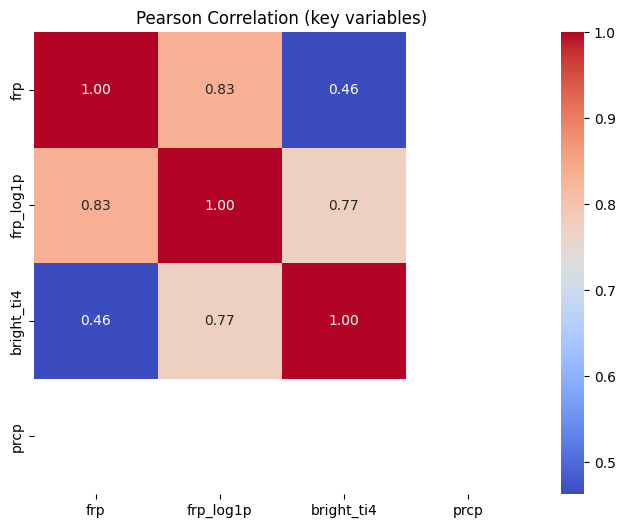

In [15]:
# Cell 8: summary stats of key variables
key_vars = [v for v in ['frp','frp_log1p','bright_ti4','temperature','prcp','awnd'] if v in merged_df.columns]
display(merged_df[key_vars].describe().T)

# Skewness, kurtosis
for c in key_vars:
    print(f"{c}: skew={merged_df[c].skew():.3f}, kurtosis={merged_df[c].kurtosis():.3f}")

# Correlation matrix (pearson)
corr = merged_df[key_vars].corr(method='pearson')
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Pearson Correlation (key variables)")
plt.show()

In [16]:
from sklearn.decomposition import PCA

# Cell 9: PCA on standardized numeric features (take top N)
pca_vars = [c for c in merged_df.columns if c.endswith('_std')]  # standardized numeric
if len(pca_vars) >= 3:
    pca = PCA(n_components=min(6, len(pca_vars)))
    pca_res = pca.fit_transform(merged_df[pca_vars].fillna(0))
    print("Explained variance ratios:", pca.explained_variance_ratio_.round(3))
    # attach as columns
    for i in range(pca_res.shape[1]):
        merged_df[f'pca_{i+1}'] = pca_res[:, i]
else:
    print("Not enough standardized numeric features for PCA.")

Explained variance ratios: [0.455 0.254 0.145 0.109 0.037 0.   ]


In [17]:
# Cell 10: Data quality checks
n_rows = len(merged_df)
completeness = 1 - (merged_df.isna().sum() / n_rows)
inconsistent_coords = ((merged_df['lat'] < -90) | (merged_df['lat'] > 90) | (merged_df['lon'] < -180) | (merged_df['lon'] > 180)).sum()
print(f"Row count: {n_rows}; Inconsistent coordinates: {inconsistent_coords}")
print("Top columns by completeness:")
display(completeness.sort_values().head(10))

# Check temporal coverage
print("Date range:", merged_df['acq_date'].min(), "to", merged_df['acq_date'].max())

Row count: 9360; Inconsistent coordinates: 0
Top columns by completeness:


,0
date,0.105983
acq_date,1.000000
lon,1.000000
lat,1.000000
longitude_rounded,1.000000
bright_ti4,1.000000
bright_ti5,1.000000
latitude_rounded,1.000000
frp,1.000000
confidence,1.000000


Date range: 2025-10-12 00:00:00 to 2025-10-17 00:00:00


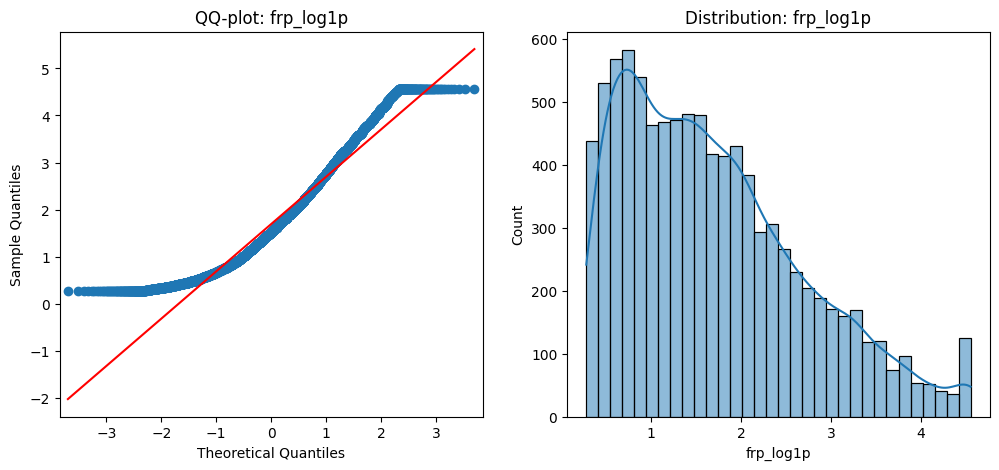

Shapiro-Wilk test: stat=0.9425, p=2.368e-40


In [18]:
# Cell 11: QQ plots and Shapiro for FRP (or log-FRP)
import statsmodels.api as sm
from scipy import stats
target = 'frp_log1p' if 'frp_log1p' in merged_df.columns else 'frp'
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
sm.qqplot(merged_df[target].dropna(), line='s', ax=ax1)
ax1.set_title(f"QQ-plot: {target}")
ax2 = fig.add_subplot(1,2,2)
sns.histplot(merged_df[target].dropna(), kde=True)
ax2.set_title(f"Distribution: {target}")
plt.show()

# Shapiro-Wilk test (on a sample, as full sample may be large)
sample = merged_df[target].dropna().sample(min(5000, len(merged_df)), random_state=42) # Added random_state for reproducibility
shap_stat, shap_p = stats.shapiro(sample)
print("Shapiro-Wilk test: stat=%.4f, p=%.4g" % (shap_stat, shap_p))

In [19]:
# Cell 12: For merged data, check how many firms rows had a matched weather record (merge_asof tolerance)
matched = merged_df['date'].notna().mean() * 100
print(f"Percent of FIRMS rows with attached NOAA date record: {matched:.2f}%")

# If station info present, check distinct station counts
if 'station' in merged_df.columns:
    print("Distinct NOAA stations in merged df:", merged_df['station'].nunique())

Percent of FIRMS rows with attached NOAA date record: 10.60%


# Visualizations

In [20]:
import folium
from folium.plugins import HeatMap

map_center = [merged_df['lat'].median(), merged_df['lon'].median()]
m = folium.Map(location=map_center, zoom_start=5)
heat_data = merged_df[['lat','lon','frp']].dropna().values.tolist() if 'frp' in merged_df.columns else merged_df[['lat','lon']].values.tolist()
HeatMap(heat_data, radius=6, max_zoom=10).add_to(m)
m

Viz1 skipped (error): name 'save_show' is not defined


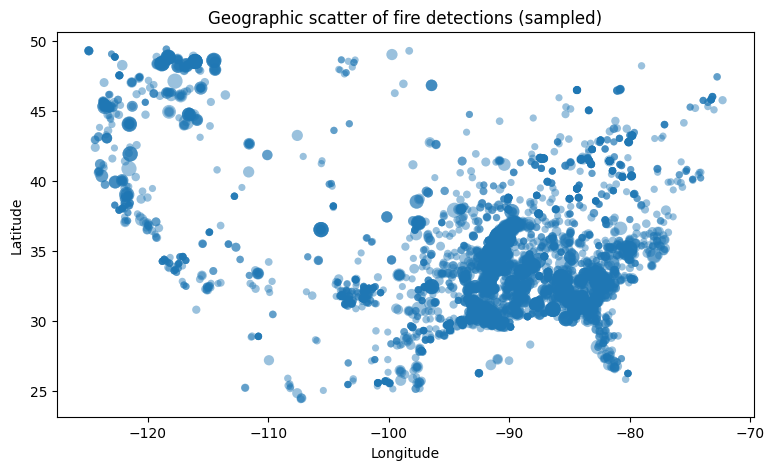

In [21]:
col_lat = 'lat'
col_lon = 'lon'
col_frp = 'frp'

if col_lat and col_lon:
    try:
        fig, ax = plt.subplots(figsize=(9,5))
        subs = merged_df.dropna(subset=[col_lat,col_lon]).sample(min(5000, len(merged_df)))  # sample for speed
        sizes = None
        if col_frp and col_frp in subs.columns:
            # normalize sizes
            s = subs[col_frp].fillna(0).values
            sizes = 10 + (np.clip(s, np.percentile(s,5), np.percentile(s,95)) - np.percentile(s,5))
            sizes = (sizes / sizes.max()) * 120
        ax.scatter(subs[col_lon], subs[col_lat], s=sizes, alpha=0.45, linewidth=0, edgecolor=None)
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
        ax.set_title("Geographic scatter of fire detections (sampled)")
        save_show(fig, "viz1_geo_scatter_frp.png")
    except Exception as e:
        print("Viz1 skipped (error):", e)
else:
    print("Viz1 skipped: lat/lon missing")

Viz2 skipped (error): name 'save_show' is not defined


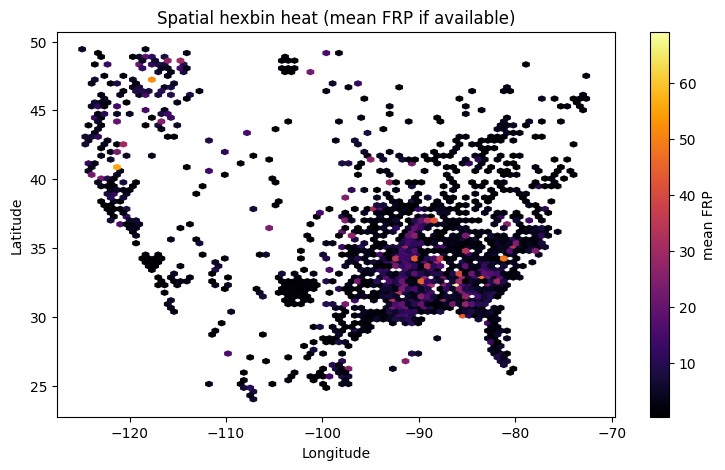

In [22]:
if col_lat and col_lon:
    try:
        fig, ax = plt.subplots(figsize=(9,5))
        x = merged_df[col_lon].values
        y = merged_df[col_lat].values
        if col_frp:
            w = merged_df[col_frp].fillna(0).values
            hb = ax.hexbin(x, y, C=w, reduce_C_function=np.mean, gridsize=80, cmap='inferno')
            cb = fig.colorbar(hb, ax=ax)
            cb.set_label("mean FRP")
        else:
            hb = ax.hexbin(x, y, gridsize=80, cmap='inferno')
            fig.colorbar(hb, ax=ax)
        ax.set_title("Spatial hexbin heat (mean FRP if available)")
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
        save_show(fig, "viz2_hexbin_spatial.png")
    except Exception as e:
        print("Viz2 skipped (error):", e)

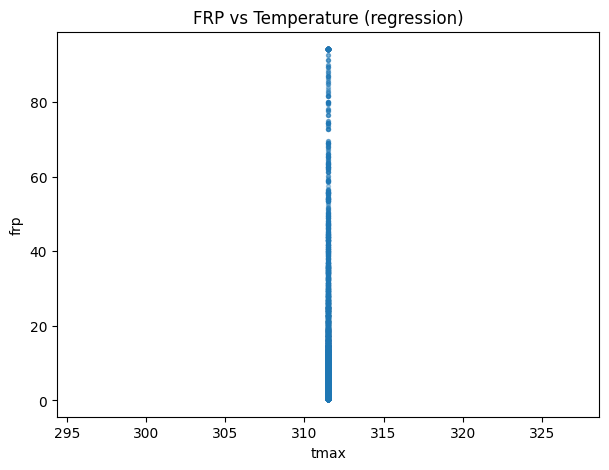

In [23]:
col_frp = 'frp'
col_tmax = 'tmax'

if col_frp and col_tmax in merged_df.columns:
    try:
        fig, ax = plt.subplots(figsize=(7,5))
        sns.regplot(data=merged_df, x=col_tmax, y=col_frp, scatter_kws={'s':8, 'alpha':0.35}, line_kws={'color':'red'}, ax=ax)
        ax.set_title("FRP vs Temperature (regression)")
        ax.set_xlabel(col_tmax); ax.set_ylabel(col_frp)
        plt.show()
    except Exception as e:
        print("Viz3 skipped (error):", e)
else:
    print("Viz3 skipped: frp or temperature missing")

/tmp/ipython-input-2215628874.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cnt.index, y=cnt.values, ax=ax, palette='magma')


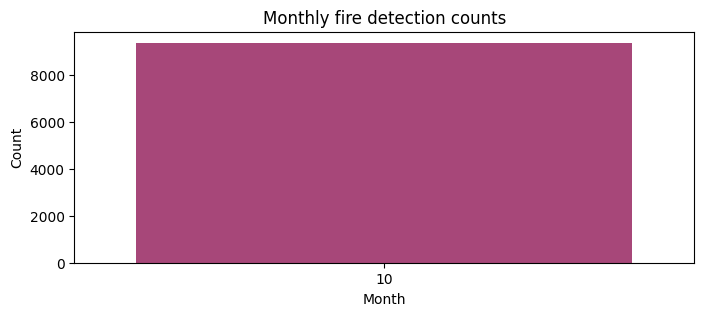

In [24]:
col_date = 'acq_date'

if col_date:
    try:
        merged_df['__month'] = pd.to_datetime(merged_df[col_date]).dt.month
        cnt = merged_df['__month'].value_counts().sort_index()
        fig, ax = plt.subplots(figsize=(8,3))
        sns.barplot(x=cnt.index, y=cnt.values, ax=ax, palette='magma')
        ax.set_xlabel("Month"); ax.set_ylabel("Count"); ax.set_title("Monthly fire detection counts")
        plt.show()
        merged_df.drop(columns='__month', inplace=True)
    except Exception as e:
        print("Viz5 skipped (error):", e)
else:
    print("Viz5 skipped: date missing")

Viz6 skipped (error): name 'save_show' is not defined


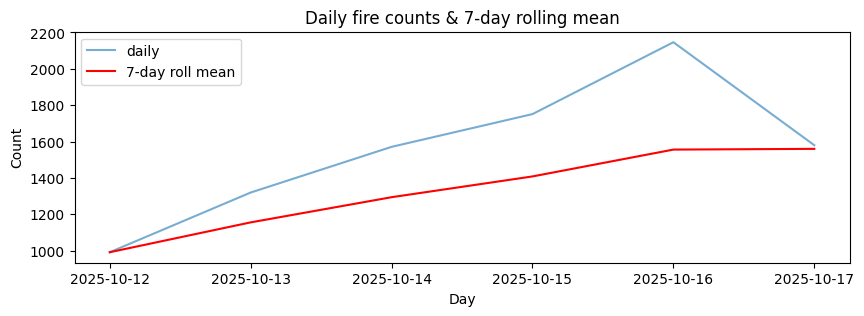

In [25]:
if col_date:
    try:
        merged_df['__day'] = pd.to_datetime(merged_df[col_date]).dt.date
        daily = merged_df.groupby('__day').size().rename('count').reset_index()
        daily['__day'] = pd.to_datetime(daily['__day'])
        daily = daily.sort_values('__day')
        daily['roll7'] = daily['count'].rolling(7, min_periods=1).mean()
        fig, ax = plt.subplots(figsize=(10,3))
        ax.plot(daily['__day'], daily['count'], alpha=0.6, label='daily')
        ax.plot(daily['__day'], daily['roll7'], color='red', label='7-day roll mean')
        ax.set_title("Daily fire counts & 7-day rolling mean")
        ax.set_xlabel("Day"); ax.set_ylabel("Count"); ax.legend()
        save_show(fig, "viz6_daily_counts_roll.png")
        merged_df.drop(columns='__day', inplace=True)
    except Exception as e:
        print("Viz6 skipped (error):", e)

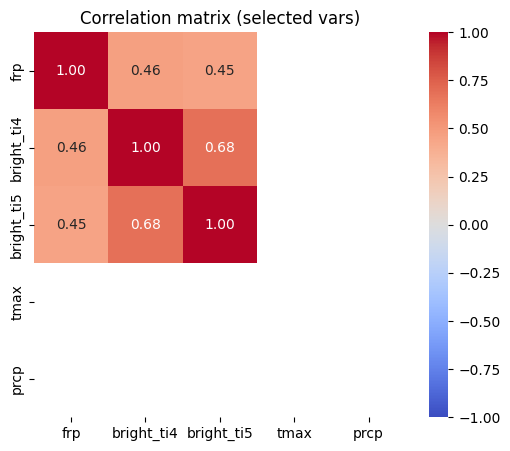

In [26]:
col_frp = 'frp'
col_tmax = 'tmax'
col_prcp = 'prcp'

num_candidates = [col_frp, 'bright_ti4', 'bright_ti5', col_tmax, col_prcp]
num_cols = [c for c in num_candidates if c and c in merged_df.columns]
if len(num_cols) >= 2:
    try:
        corr_df = merged_df[num_cols].copy().apply(pd.to_numeric, errors='coerce')
        corr = corr_df.corr()
        fig, ax = plt.subplots(figsize=(6,5))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax, vmin=-1, vmax=1)
        ax.set_title("Correlation matrix (selected vars)")
        plt.show()
    except Exception as e:
        print("Viz7 skipped (error):", e)
else:
    print("Viz7 skipped: not enough numeric weather/fire columns for correlation")

In [27]:
import plotly.express as px

fig = px.scatter_mapbox(
    merged_df,
    lat="lat",
    lon="lon",
    color="bright_ti4",
    size="frp",
    color_continuous_scale="Inferno",
    mapbox_style="carto-positron",
    title="Geographical Distribution of Wildfire Brightness & FRP",
    zoom=3
)
fig.show()

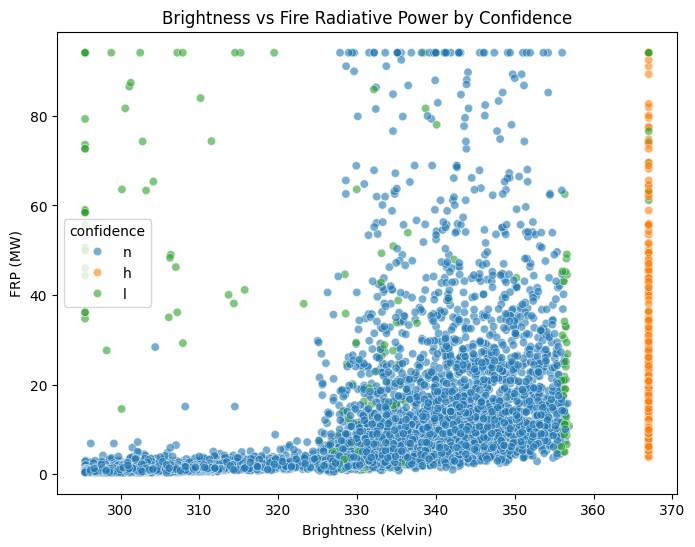

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x='bright_ti4', y='frp', hue='confidence', alpha=0.6)
plt.title("Brightness vs Fire Radiative Power by Confidence")
plt.xlabel("Brightness (Kelvin)")
plt.ylabel("FRP (MW)")
plt.show()

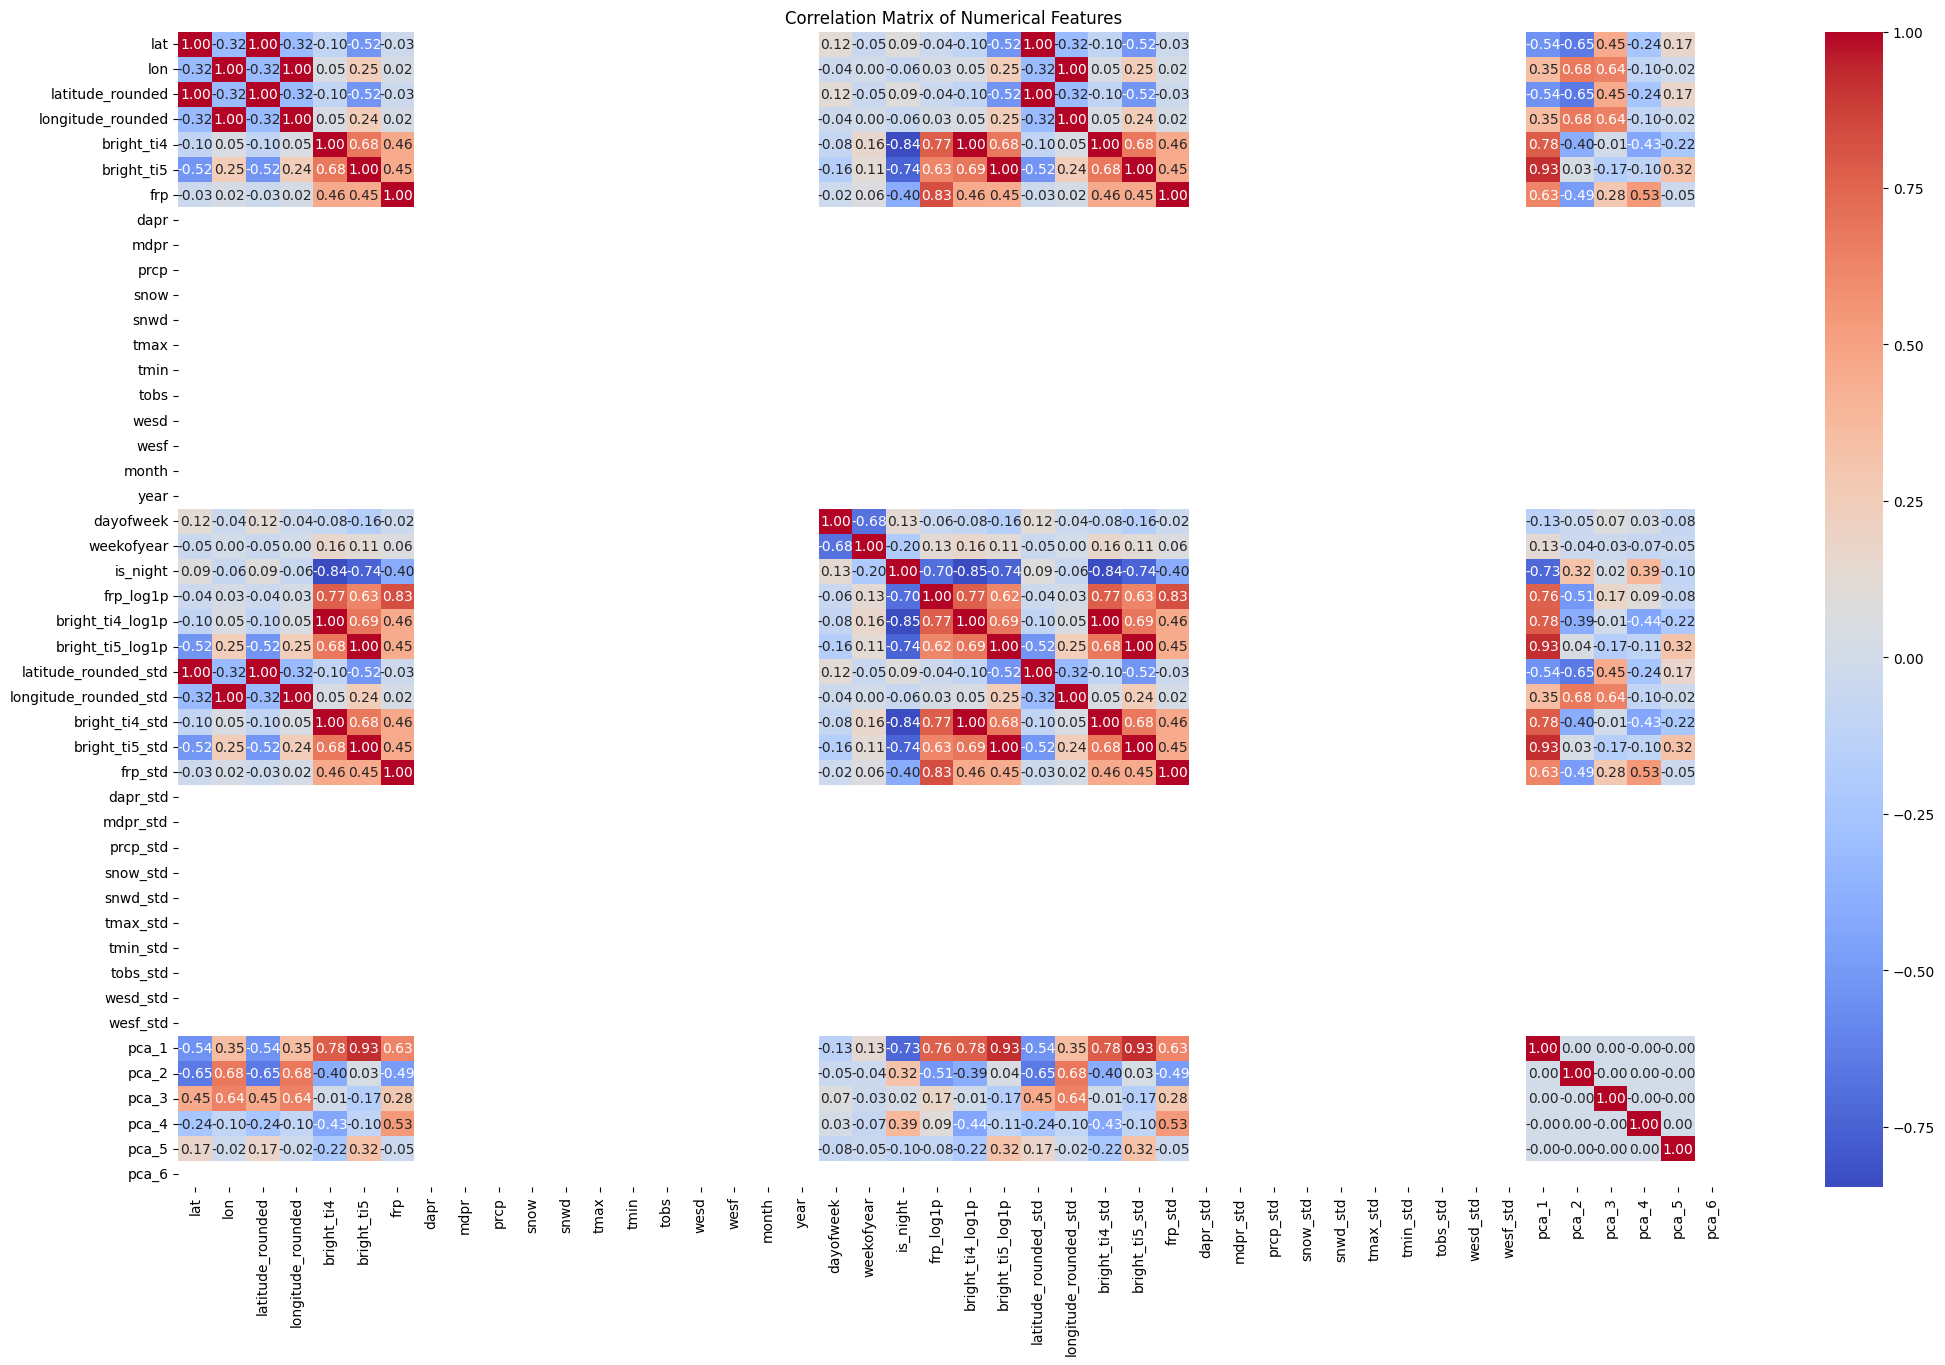

In [37]:
corr = merged_df.select_dtypes('number').corr()
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

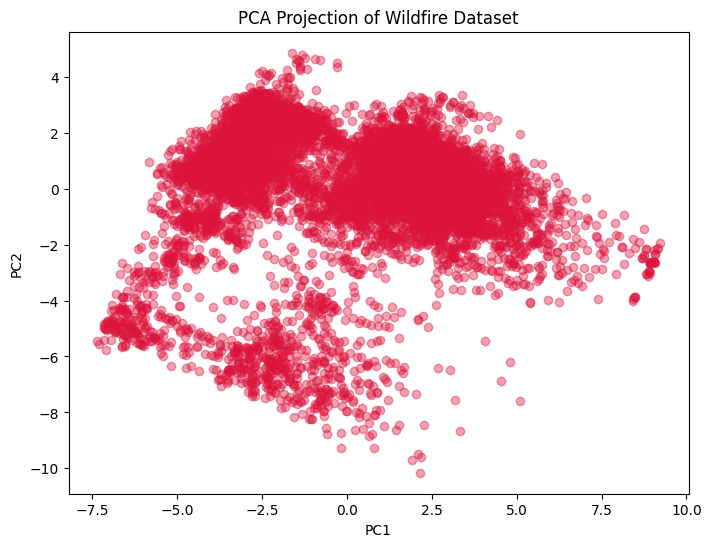

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

num_df = merged_df.select_dtypes('number').dropna()
scaled = StandardScaler().fit_transform(num_df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.4, c='crimson')
plt.title("PCA Projection of Wildfire Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
